In [47]:
# Sean

# August LOG for DESI project

In [2]:
def nanmask(array):
    mask = (np.isnan(array) == False)
    print(mask)
    newarray = array[mask]
    return newarray, mask

def seanscat(x,y):
    
    xlab = input("What would you like the x label to be?")
    ylab = input("What would you like the y label to be?")
    pointsize = input("What would you like the size of the scatter points to be?")
    
    plt.scatter(x,y,s=int(pointsize))
    plt.xlim(0.9*min(x),1.1*max(x))
    plt.ylim(0.9*min(y),1.1*max(y))
    plt.grid()
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(xlab+" vs. "+ylab)
    
    plt.show()
def reducer3(df,keycol):
    delindex=[]
    for i in range(len(keycol)):
        if np.isnan(keycol[i])==True:
            delindex.append(i)
    return df.drop(delindex)

In [3]:
import pandas as pd
import operator
import numpy as np
import scipy.stats as sps

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import corner

import matplotlib as mpl
%matplotlib inline

import emcee
import pymc3 as pm

from astropy.table import Table
import astropy.io as asio
from astropy.io import fits

/Users/sean/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/sean/anaconda3/lib/python3.6/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/Users/sean/anaconda3/lib/python3.6/s

In [4]:
BDecLabel = "Log(H\u03B1/H\u03B2)"
LCOLabel = "Log(L$_{CO}$)"
MDustLabel = "Log(M$_{Dust}$/M$_*$)"
MH2Label = "Log(M H$_2$/M$_*$)"
StarMassLabel = "Log(M$_{Star}$/M$_*$)"
SFRLabel = "SFR"
GasFracLabel = "GasFrac"

### Data importing and manipulation

In [6]:
newfilename = "280_hier_normal_hrs_filter_fit_with_jingle_separate_ms_fluxes_v13.csv"
newdfHRS = pd.read_csv(newfilename)

bosfilename = "table6_boselli_2015_fluxes.csv"
bosdf = pd.read_csv(bosfilename)
newdfHRS = newdfHRS[2:]
 
bosdf["logM Dust"] = np.nan
bosdf["low err logM Dust"] = np.nan
bosdf["up err logM Dust"] = np.nan
bosdf["expAB_r"] = np.nan

for i in range(len(bosdf["# HRS index"])):
    for j in range(2,len(newdfHRS["#"])+2):
        if bosdf["# HRS index"][i]==int(newdfHRS["#"][j]):
            bosdf["logM Dust"][i] = newdfHRS["logM SMBB "][j]
            bosdf["low err logM Dust"][i] = newdfHRS[" low err logM "][j]
            bosdf["up err logM Dust"][i] = newdfHRS[" up err logM "][j]
            
jingmdrname = "JINGLE_master.fits"

jingmdrfitstab = Table.read(jingmdrname, format='fits') # THIS IS THE MASTER FILE!
jingmdrdf = jingmdrfitstab.to_pandas() # This one uses SPECOBJID

HRSname = "hrs_inclination_expab_r_from_sdss.csv"
HRSexdf = pd.read_csv(HRSname)

for i in range(len(bosdf["# HRS index"])):
    for j in range(len(HRSexdf["# HRS index"])):
        if bosdf["# HRS index"][i]==int(HRSexdf["# HRS index"][j]):
            bosdf["expAB_r"][i] = HRSexdf["expAB_r"][j]

sdssfits_image_filename = 'SDSS_DR14Query_EmissionLines.fits'

sdssfitstab = Table.read(sdssfits_image_filename, format='fits')
sdssfitsdf = sdssfitstab.to_pandas() # This one uses specObjID

sdssfitsdf["Bdec"] = np.log10(sdssfitsdf["FLUX_HA_6562"]/sdssfitsdf["FLUX_HB_4861"])
sdssfitsdf["HA SNR"] = sdssfitsdf["FLUX_HA_6562"]/sdssfitsdf["FLUX_HA_6562_ERR"]
sdssfitsdf["HB SNR"] = sdssfitsdf["FLUX_HB_4861"]/sdssfitsdf["FLUX_HB_4861_ERR"]
sdssfitsdf["Bdec_err"] = sdssfitsdf["Bdec"]*np.sqrt((sdssfitsdf["FLUX_HA_6562_ERR"]/sdssfitsdf["FLUX_HA_6562"])**2+(sdssfitsdf["FLUX_HB_4861_ERR"]/sdssfitsdf["FLUX_HB_4861"])**2)

newtmp = ""
sdssjingIDList = []

for i in range(len(sdssfitsdf["COL0"])):
    newtmp = sdssfitsdf["COL0"][i]
    sdssjingIDList.append(int(newtmp[6:]))
    
sdssfitsdf["JingID"] = sdssjingIDList

jingmdrdf["BDec"] = np.nan
jingmdrdf["BDecerr"] = np.nan
jingmdrdf["HA SNR"] = np.nan
jingmdrdf["HB SNR"] = np.nan

for i in range(int(len(sdssfitsdf["JingID"]))):
    for j in range(int(len(jingmdrdf["IDNUM"]))):
        if(jingmdrdf["IDNUM"][j]==sdssfitsdf["JingID"][i]):
            jingmdrdf["BDec"][j] = sdssfitsdf["Bdec"][i]
            jingmdrdf["BDecerr"][j] = sdssfitsdf["Bdec_err"][i]
            jingmdrdf["HA SNR"][j] = sdssfitsdf["HA SNR"][i]
            jingmdrdf["HB SNR"][j] = sdssfitsdf["HB SNR"][i]
            
filename = "JINGLE_hierarchical_dust_June19.csv"
dfJingle = pd.read_csv(filename)

tmpstring = ""
numlist = []

for i in range(len(dfJingle[" Name "])):
    tmpstring = dfJingle[" Name "][i]
    numlist.append(int(tmpstring[6:]))
    
dfJingle["Jing ID"] = numlist
jingmdrdf["logMDust"] = np.nan
jingmdrdf["logMDust uperr"] = np.nan
jingmdrdf["logMDust lowerr"] = np.nan

for i in range(len(dfJingle["Jing ID"])):
    for j in range(len(jingmdrdf["BDec"])):
        if dfJingle["Jing ID"][i]==jingmdrdf["IDNUM"][j]:
            jingmdrdf["logMDust"][j] = dfJingle["logM SMBB "][i]
            jingmdrdf["logMDust uperr"][j] = dfJingle[" low err logM "][i]
            jingmdrdf["logMDust lowerr"][j] = dfJingle[" up err logM "][i]
            
MPAname = "JINGLE_193_MPA-JHU_lines_dr7_Ha_Hbeta.csv"
MPAdf = pd.read_csv(MPAname)
MPAdf["Log Bdec"] = np.log10(MPAdf["H_ALPHA_FLUX"]/MPAdf["H_BETA_FLUX"])
MPAdf["Bdec err"] = np.sqrt((MPAdf["H_BETA_FLUX_ERR"]/MPAdf["H_BETA_FLUX"])**2+(MPAdf["H_ALPHA_FLUX_ERR"]*(MPAdf["H_ALPHA_FLUX"]/(-MPAdf["H_BETA_FLUX"]**2)))**2)
MPAdf["Log Bdec err"] = MPAdf["Bdec err"]/(np.log(10)*(MPAdf["H_ALPHA_FLUX"]/MPAdf["H_BETA_FLUX"])) # PICKUP HERE
jingmdrdf["MPA LBdec"] = np.nan
jingmdrdf["MPA LBdec err"] = np.nan

for i in range(len(MPAdf["#JINGLE ID"])):
     for j in range(len(jingmdrdf["BDec"])):
            if jingmdrdf["IDNUM"][j]==MPAdf["#JINGLE ID"][i]:
                jingmdrdf["MPA LBdec"][j] = MPAdf["Log Bdec"][i]
                jingmdrdf["MPA LBdec err"][j] = MPAdf["Log Bdec err"][i]

/Users/sean/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/sean/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sean/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sean/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A

In [7]:
for i in range(len(bosdf["Halpha"])):
    if bosdf["S/N(Ha)"][i]!="-":
        bosdf["S/N(Ha)"][i] = float(bosdf["S/N(Ha)"][i])
    else:
        bosdf["S/N(Ha)"][i] = np.nan
    if bosdf["SN(Hbeta)"][i]!= "-":
        bosdf["SN(Hbeta)"][i] = float(bosdf["SN(Hbeta)"][i])
    else:
        bosdf["SN(Hbeta)"][i] = np.nan
    if bosdf["Halpha"][i]!="-":
        bosdf["Halpha"][i] = float(bosdf["Halpha"][i])
    else:
        bosdf["Halpha"][i] = np.nan
    if bosdf["Hbeta"][i] != "-":
        bosdf["Hbeta"][i] = float(bosdf["Hbeta"][i])
    else:
        bosdf["Hbeta"][i] = np.nan

/Users/sean/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sean/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/sean/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by Interactive

In [8]:
jingmdrdf.columns.values

array(['SDSS9', 'JINGLEID', 'IDNUM', 'SDSSID', 'OBJID', 'SPECOBJID',
       'PLATE', 'MJD', 'FIBERID', 'RA', 'DEC', 'Z', 'Z_ERR', 'DL',
       'AGNCLASS', 'N2HA', 'O3HB', 'Z_PP04_N2', 'Z_PP04_O3N2', 'Z_MZR',
       'LOGMSTAR', 'LOGMSTAR_MAGPHYS', 'LOGMSTAR_MAGPHYS_ERR',
       'LOGMSTAR_GRASIL', 'LOGMSTAR_WISE', 'LOGMSTAR_WISE_ERR',
       'LOGMSTAR_CHANG', 'LOGMSTAR_CHANG_ERR', 'LOGMSTAR_MPAJHU',
       'LOGMSTAR_MPAJHU_ERR', 'LOGMSTAR_BC03', 'LOGMSTAR_BC03_ERR',
       'LOGMUST', 'CINDEX', 'AXISRATIO', 'INCL', 'PETRORAD_KPC',
       'PETROR50_KPC', 'RE_R', 'LOGSFR_MPAJHU', 'LOGSFR_MPAJHU_ERR',
       'LOGSFR_CHANG', 'LOGSFR_CHANG_ERR', 'LOGSFR_IRNUV',
       'LOGSFR_IRNUV_ERR', 'LOGSFR_IRFUV', 'LOGSFR_IRFUV_ERR',
       'LOGSFR_MAGPHYS', 'LOGSFR_MAGPHYS_ERR', 'LOGSFR_GRASIL',
       'LOGSFR_NUVCE01', 'LOGSFR_NUVCE01_ERR', 'LOGSFR_NUVJRM',
       'LOGSFR_NUVJRM_ERR', 'LOGSFR_FUVCE01', 'LOGSFR_FUVCE01_ERR',
       'LOGSFR_FUVJRM', 'LOGSFR_FUVJRM_ERR', 'AIRX', 'FUVK', 'LOGL12UM',
      

In [9]:
filtered_Jing_LCO = []
filtered_Jing_LCOerr = []
filtered_Jing_Bdec = []
filtered_Jing_Bdecerr = []
filtered_Jing_incl = []
filtered_Jing_Mdust = []
filtered_Jing_Mdustuperr = []
filtered_Jing_Mdustlowerr = []

jingSNlim = 5
for i in range(len(jingmdrdf["LOGLCO21"])):
    if jingmdrdf["HA SNR"][i]>=jingSNlim and jingmdrdf["HB SNR"][i]>=jingSNlim:
        filtered_Jing_LCO.append(jingmdrdf["LOGLCO21"][i])
        filtered_Jing_LCOerr.append(jingmdrdf["LOGLCO21_ERR"][i])
        filtered_Jing_Bdec.append(jingmdrdf["BDec"][i])
        filtered_Jing_Bdecerr.append(jingmdrdf["BDecerr"][i])
        filtered_Jing_incl.append(jingmdrdf["INCL"][i])
        filtered_Jing_Mdust.append(jingmdrdf["logMDust"][i])
        filtered_Jing_Mdustuperr.append(jingmdrdf["logMDust uperr"][i])
        filtered_Jing_Mdustlowerr.append(jingmdrdf["logMDust lowerr"][i])
        
# for i in range(len(filtered_Jing_Mdust)):
#     print(i,filtered_Jing_Mdust[i])
print(len(filtered_Jing_Bdec))
delindex = [61]
filtered_Jing_LCO = [i for j, i in enumerate(filtered_Jing_LCO) if j not in delindex]
filtered_Jing_LCOerr = [i for j, i in enumerate(filtered_Jing_LCOerr) if j not in delindex]
filtered_Jing_Bdec = [i for j, i in enumerate(filtered_Jing_Bdec) if j not in delindex]
filtered_Jing_Bdecerr = [i for j, i in enumerate(filtered_Jing_Bdecerr) if j not in delindex]
filtered_Jing_incl = [i for j, i in enumerate(filtered_Jing_incl) if j not in delindex]
filtered_Jing_Mdust = [i for j, i in enumerate(filtered_Jing_Mdust) if j not in delindex]
filtered_Jing_Mdustuperr = [i for j, i in enumerate(filtered_Jing_Mdustuperr) if j not in delindex]
filtered_Jing_Mdustlowerr = [i for j, i in enumerate(filtered_Jing_Mdustlowerr) if j not in delindex]

print(len(filtered_Jing_Bdec)) # only run this once!!
        
filtered_HRS_DustM = []
filtered_HRS_DustMuperr = []
filtered_HRS_DustMlowerr = []
filtered_HRS_BDec = []
filtered_HRS_BDecerr = []
filtered_HRS_expAB = []
filtered_HRS_incl = []

HRS_SNlim = 5
q=0.13

for i in range(len(bosdf["Hbeta"])):
    if float(bosdf["S/N(Ha)"][i])>=HRS_SNlim and float(bosdf["SN(Hbeta)"][i])>=HRS_SNlim:
        filtered_HRS_DustM.append(bosdf["logM Dust"][i])
        filtered_HRS_DustMuperr.append(bosdf["up err logM Dust"][i])
        filtered_HRS_DustMlowerr.append(bosdf["low err logM Dust"][i])
        filtered_HRS_BDec.append(np.log10(float(bosdf["Halpha"][i])/float(bosdf["Hbeta"][i])))
        filtered_HRS_BDecerr.append(np.sqrt((bosdf["Hbeta"][i]/bosdf["SN(Hbeta)"][i])**2+(bosdf["Halpha"][i]/bosdf["S/N(Ha)"][i])**2)/(np.log(10)*(float(bosdf["Halpha"][i])/float(bosdf["Hbeta"][i]))))
        filtered_HRS_expAB.append(bosdf["expAB_r"][i])
        filtered_HRS_incl.append(np.arccos(((bosdf["expAB_r"][i]**2-q**2)/(1-q**2))-0.5))

179
178


In [10]:
PearsonRhoHRS, PearsonPValHRS = sps.pearsonr(filtered_HRS_BDec,filtered_HRS_DustM) # Gets more correlated as approaches abs(1)
SpearmanRhoHRS, SpearmanPValHRS = sps.spearmanr(filtered_HRS_BDec,filtered_HRS_DustM) # More monotonically correlated as it gets closer to 1
PearsonRhoJing, PearsonPValJing = sps.pearsonr(filtered_Jing_Bdec,filtered_Jing_Mdust)
SpearmanRhoJing, SpearmanPValJing = sps.spearmanr(filtered_Jing_Bdec,filtered_Jing_Mdust)

In [11]:
for i in range(len(filtered_Jing_Bdec)):
    if(filtered_Jing_Bdec[i]>1):
        print(filtered_Jing_Bdec[i],i)

1.1668946743011475 19


In [12]:
coldfilename = "xCOLDGASS_all.fits"

coldfitstab = Table.read(coldfilename, format='fits')
coldfitsdf = coldfitstab.to_pandas()
coldfitsdf["LOGLCO"] = np.log10(coldfitsdf["LCO"])
coldfitsdf["LOGLCO_COR"] = np.log10(coldfitsdf["LCO_COR"])
coldfitsdf["LOGLCO_ERR"] = coldfitsdf["LCO_ERR"]/(np.log(10)*coldfitsdf["LCO"])
coldfitsdf["LOGLCO_COR_ERR"] = coldfitsdf["LCO_COR_ERR"]/(np.log(10)*coldfitsdf["LCO_COR"])

print(coldfitsdf.columns.values)

['ID' 'SAMPLE' 'AGCNR' 'SDSS' 'OBJID' 'SPECOBJID' 'PLATEID' 'MJD'
 'FIBERID' 'RA' 'DEC' 'Z_SDSS' 'LUMDIST' 'INCL' 'NUVR_GEXT' 'D25_G'
 'R50_R' 'R50KPC' 'R50_Z' 'R50_NUV' 'R50_NUV_ERR' 'R50_SFR' 'R50_SFR_ERR'
 'MASS' 'MASS_ERR' 'MUST' 'CINDX' 'SFR_SDSS' 'SFR_SED' 'SFR_BEST'
 'SFR_ERR' 'SFR_CASE' 'SFR_IR' 'SFR_IR_ERR' 'SSFR' 'DELTAMS_P10'
 'DELTAMS_S16' 'DELTAMS_W12' 'DELTAMS_W14' 'D4000' 'N2HA' 'O3HB' 'BALMER'
 'BALMER_ERR' 'AGNCLASS' 'Z_PP04_N2' 'Z_PP04_O3N2' 'Z_MZR' 'Z_FIBER'
 'HISRC' 'ZHI' 'W50COR' 'LOGMHI' 'LOGMHIMS' 'HICONF' 'GROUPID'
 'ENVIRONMENT' 'NGROUP' 'LOGMHALO' 'LOGRNORM' 'FLAG_CO' 'XCO' 'XCO_G12'
 'XCO_A16' 'XCO_A16_ERR' 'ICO' 'ICO_ERR' 'ICO_COR' 'ICO_COR_ERR' 'F_RECOV'
 'LCO' 'LCO_ERR' 'LCO_COR' 'LCO_COR_ERR' 'RMS_CO' 'SN_CO' 'WCO' 'WCO_FLAG'
 'Z_CO' 'WCO_TFR' 'WCO_TFR_ERR' 'WCO_TFR_FLAG' 'LOGMH2' 'LOGMH2_ERR'
 'LIMLOGMH2' 'MH2_ERR' 'LOGMH2MS' 'LOGRMOL' 'FLAGRMOL' 'FLAG_CO21' 'ICO21'
 'ICO21_ERR' 'ICO21_COR' 'LCO21' 'LCO21_ERR' 'LCO21_COR' 'RMS_CO21'
 'SN_CO21' 'WCO21' 'W

In [13]:
filtLCOX = []
filtLCOerrX = []
filtLCOCORX = []
filtLCOCORerrX = []
filtBalmX = []
filtBalmErrX = []
filtMH2 = []
filtMH2err = []

delindex = []

# print(coldfitsdf["FLAG_CO21"])

for i in range(len(coldfitsdf["LOGLCO"])): # xCOLD
    if np.asarray(coldfitsdf["FLAG_CO21"][i])==1 and np.asarray(coldfitsdf["AGNCLASS"][i])==1: # and coldfitsdf["LOGMH2"][i]>2
        filtLCOX.append(np.asarray(coldfitsdf["LOGLCO"][i]))
        filtLCOerrX.append(np.asarray(coldfitsdf["LOGLCO_ERR"][i]))
        filtLCOCORX.append(np.asarray(coldfitsdf["LOGLCO_COR"][i]))
        filtLCOCORerrX.append(np.asarray(coldfitsdf["LOGLCO_COR_ERR"][i]))
        filtBalmX.append(np.asarray(coldfitsdf["BALMER"][i]))
        filtBalmErrX.append(np.asarray(coldfitsdf["BALMER_ERR"][i]))
        filtMH2.append(np.asarray(coldfitsdf["LOGMH2"][i]))
        filtMH2err.append(np.asarray(coldfitsdf["LOGMH2_ERR"][i]))
    else:
        delindex.append(i)
        print(coldfitsdf["SFR_BEST"][i])

coldfitsdf = coldfitsdf.drop(delindex)
# print(coldfitsdf["AGNCLASS"])
# remove nans from xCold
coldfitsdf = reducer3(coldfitsdf,np.asarray(coldfitsdf["LOGLCO"]))
coldfitsdf = reducer3(coldfitsdf,np.asarray(coldfitsdf["LOGLCO_ERR"]))
coldfitsdf = reducer3(coldfitsdf,np.asarray(coldfitsdf["LOGMH2"]))
coldfitsdf = reducer3(coldfitsdf,np.asarray(coldfitsdf["LOGMH2_ERR"]))
coldfitsdf = reducer3(coldfitsdf,np.asarray(coldfitsdf["BALMER"]))
coldfitsdf = reducer3(coldfitsdf,np.asarray(coldfitsdf["BALMER_ERR"]))
coldfitsdf = reducer3(coldfitsdf,np.asarray(coldfitsdf["INCL"]))
coldfitsdf = reducer3(coldfitsdf,np.asarray(coldfitsdf["N2HA"]))
coldfitsdf.to_csv("xColdFilt.csv")

delindex = []

filtLCOJing = []
filtBDecSDSSJing = [] # Marking out CO detection in the JINGLE sample
filtBDecMPAJing = []
filtBDecerrMPAJing = []
filtMDust = []
filtMDustuperr = []
filtMDustlowerr = []
filtINCL = []
filtIDnum = []

for i in range(len(jingmdrdf["FLAG_CO"])): # ALL THE JINGLE STUFF
    if np.asarray(jingmdrdf["AGNCLASS"][i])==1 and np.asarray(jingmdrdf['HA SNR'][i])>=jingSNlim and np.asarray(jingmdrdf['HB SNR'][i])>=jingSNlim:
        filtLCOJing.append(jingmdrdf["LOGLCO21"][i])
        filtBDecSDSSJing.append(jingmdrdf["BDec"][i])
        filtBDecMPAJing.append(jingmdrdf["MPA LBdec"][i])
        filtMDust.append(jingmdrdf["logMDust"][i])
        filtIDnum.append(jingmdrdf["IDNUM"][i])
        filtINCL.append(jingmdrdf["INCL"][i])
        filtMDustuperr.append(jingmdrdf["logMDust uperr"][i])
        filtMDustlowerr.append(jingmdrdf["logMDust lowerr"][i])
        filtBDecerrMPAJing.append(jingmdrdf["MPA LBdec err"][i])
    else:
        delindex.append(i)
        
jingmdrdf = jingmdrdf.drop(delindex)
# remove nans
jingmdrdf = reducer3(jingmdrdf,np.asarray(jingmdrdf["MPA LBdec"]))
jingmdrdf = reducer3(jingmdrdf,np.asarray(jingmdrdf["logMDust"]))
jingmdrdf = reducer3(jingmdrdf,np.asarray(jingmdrdf["logMDust uperr"]))
jingmdrdf = reducer3(jingmdrdf,np.asarray(jingmdrdf["logMDust lowerr"]))
jingmdrdf.to_csv("filtJing.csv")

0.2081601
0.013042905
0.036505617
0.15883797
2.3662374
0.07354009
0.5195145
0.2154415
0.15086988
1.2435442
0.31968674
0.73877436
0.052586995
10.745748
0.04590701
0.2478043
0.1884515
0.013041102
0.049308546
0.0512966
0.67413855
0.025587684
1.1535982
1.4963706
0.26199493
0.02109321
0.49097914
0.37546808
0.12818998
1.2793269
0.4716678
1.4949005
0.3238554
0.13312915
0.35105735
2.3472543
0.023345035
0.33515453
5.3282332
0.17164397
0.8818358
1.9031256
0.2961732
0.020047547
1.1647308
0.16026954
0.16259255
1.3404505
4.6168237
0.22498046
0.06919419
1.4761864
3.7310822
0.1075081
0.21616003
1.4764524
0.036251064
0.03991625
0.36826032
0.1112777
0.11622876
0.11178526
0.23250754
3.6067452
0.35186893
1.0889106
0.19586927
0.0054912944
2.2891016
0.1562257
0.12797031
0.9565244
0.3453206
0.07892143
2.3423948
1.2166495
1.1193643
0.025079943
0.13607967
0.15675533
4.410426
0.07075076
1.8490939
0.8171921
0.51588213
8.831408
1.0047126
0.303495
0.43921745
0.041134972
0.3057078
0.06884759
0.14369003
0.46955
7.0

In [14]:
for i in range(len(coldfitsdf)):
    if (np.asarray(coldfitsdf["SFR_BEST"])[i]<0):
        print(i)

In [15]:
for i in range(len(filtBDecMPAJing)):
    print(i,filtBDecMPAJing[i],filtMDust[i],filtINCL[i])

0 0.6727067472476351 7.664138 74.46066
1 0.5029713485867033 7.222179 68.10168
2 0.5860076245433838 7.149927000000001 52.70031
3 0.7186412352764165 7.633991 67.94655
4 0.7431896054283539 7.912412 78.48243
5 0.5837961776346698 7.4004509999999994 65.47963
6 0.6130487939983948 7.496571 79.8864
7 0.5615968909916422 7.598058 57.923233
8 0.7958391432520288 7.8914 73.12531
9 0.5158905878972508 7.511610000000001 64.64873
10 0.5077237516867857 7.09046 40.734585
11 0.5569988405309634 7.3425970000000005 52.798134
12 0.5427192700110374 7.165642999999999 52.698555
13 0.578555062680986 7.257166000000001 68.88605
14 0.5045734663963946 7.352477 52.494427
15 0.5349261879578825 7.784099 35.7909
16 0.6565899040408767 7.8891 64.33004
17 0.6494435645428842 7.357360000000001 84.780655
18 0.794358212346605 7.858458000000001 64.81416
19 0.5932533074733581 7.554005999999999 27.6334
20 0.6620926826556839 7.912884 43.558228
21 0.6807067006418349 7.412792 56.21488
22 0.6531349642548139 7.486271 39.50464
23 0.58166

In [16]:
# 63 130 have nan values for not AGN, 44 for SFing, to calculate correlation coefficients drop these indexes from MDust and BDec

# ONLY RUN THIS BAD BOY ONCE

delindex = [44]
filtLCOJing = [i for j, i in enumerate(filtLCOJing) if j not in delindex]
filtBDecSDSSJing = [i for j, i in enumerate(filtBDecSDSSJing) if j not in delindex]
filtBDecMPAJing = [i for j, i in enumerate(filtBDecMPAJing) if j not in delindex]
filtMDust = [i for j, i in enumerate(filtMDust) if j not in delindex]
filtINCL = [i for j, i in enumerate(filtINCL) if j not in delindex]
filtMDustuperr = [i for j, i in enumerate(filtMDustuperr) if j not in delindex]
filtMDustlowerr = [i for j, i in enumerate(filtMDustlowerr) if j not in delindex]
filtBDecerrMPAJing = [i for j, i in enumerate(filtBDecerrMPAJing) if j not in delindex]
filtIDnum = [i for j, i in enumerate(filtIDnum) if j not in delindex]

print(len(filtBDecMPAJing),len(filtMDust),len(filtINCL))

pd.DataFrame(data={"LCO":filtLCOJing,"BDecSDSS":filtBDecSDSSJing,"BDecMPA":filtBDecMPAJing,"MDust":filtMDust,"ID":filtIDnum,"Incl":filtINCL,"MDustuperr": filtMDustuperr, "MDustlowerr":filtMDustlowerr,"BDecerrMPA":filtBDecerrMPAJing}).to_csv("duust.csv")

115 115 115


In [17]:
print(len(filtMDust),len(filtBDecerrMPAJing))

115 115


In [18]:
PrhoMDvBdec, PPvalMDvBdec = sps.pearsonr(filtMDust,filtBDecMPAJing)
SrhoMDvBdec, SPvalMDvBdec = sps.spearmanr(filtMDust,filtBDecMPAJing)

In [19]:
print(jingmdrdf.columns.values)

['SDSS9' 'JINGLEID' 'IDNUM' 'SDSSID' 'OBJID' 'SPECOBJID' 'PLATE' 'MJD'
 'FIBERID' 'RA' 'DEC' 'Z' 'Z_ERR' 'DL' 'AGNCLASS' 'N2HA' 'O3HB'
 'Z_PP04_N2' 'Z_PP04_O3N2' 'Z_MZR' 'LOGMSTAR' 'LOGMSTAR_MAGPHYS'
 'LOGMSTAR_MAGPHYS_ERR' 'LOGMSTAR_GRASIL' 'LOGMSTAR_WISE'
 'LOGMSTAR_WISE_ERR' 'LOGMSTAR_CHANG' 'LOGMSTAR_CHANG_ERR'
 'LOGMSTAR_MPAJHU' 'LOGMSTAR_MPAJHU_ERR' 'LOGMSTAR_BC03'
 'LOGMSTAR_BC03_ERR' 'LOGMUST' 'CINDEX' 'AXISRATIO' 'INCL' 'PETRORAD_KPC'
 'PETROR50_KPC' 'RE_R' 'LOGSFR_MPAJHU' 'LOGSFR_MPAJHU_ERR' 'LOGSFR_CHANG'
 'LOGSFR_CHANG_ERR' 'LOGSFR_IRNUV' 'LOGSFR_IRNUV_ERR' 'LOGSFR_IRFUV'
 'LOGSFR_IRFUV_ERR' 'LOGSFR_MAGPHYS' 'LOGSFR_MAGPHYS_ERR' 'LOGSFR_GRASIL'
 'LOGSFR_NUVCE01' 'LOGSFR_NUVCE01_ERR' 'LOGSFR_NUVJRM' 'LOGSFR_NUVJRM_ERR'
 'LOGSFR_FUVCE01' 'LOGSFR_FUVCE01_ERR' 'LOGSFR_FUVJRM' 'LOGSFR_FUVJRM_ERR'
 'AIRX' 'FUVK' 'LOGL12UM' 'LOGMHALO_TEMPEL14' 'GROUPRANK_TEMPEL14'
 'GROUPCLASS' 'MORPH_ZOO' 'MORPH_JINGLE' 'MORPH_TEMPEL14' 'DETFLAG_850'
 'F850' 'F850ERR' 'SN850' 'F850_CORR' 'F850ERR

### Plotting

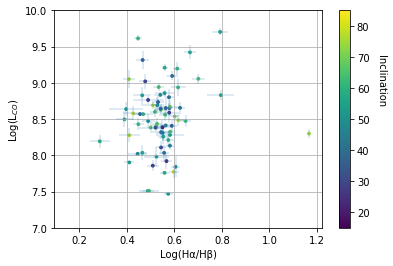

In [26]:
plt.scatter(filtered_Jing_Bdec,filtered_Jing_LCO,c=filtered_Jing_incl,s=8)
plt.errorbar(filtered_Jing_Bdec,filtered_Jing_LCO,yerr = filtered_Jing_LCOerr, xerr = filtered_Jing_Bdecerr,linestyle="none",elinewidth = 0.3)

plt.ylabel("Log(L$_{CO}$)")
plt.xlabel("Log(H\u03B1/H\u03B2)")
plt.grid()
plt.colorbar()

plt.ylim(7,10)
plt.text(1.45,8.7,"Inclination",rotation=-90)

plt.savefig("JING_BdecvsLCO.png",dpi=300)

plt.show()

Plot of JINGLE Balmer decrement vs. Log(LCO) vs. Inclination of only galaxies with Balmer decrement above a predefined signal to noise ratio here set as 5

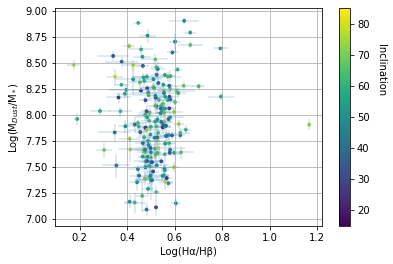

In [27]:
plt.scatter(filtered_Jing_Bdec,filtered_Jing_Mdust,c=filtered_Jing_incl,s=8)
plt.errorbar(filtered_Jing_Bdec,filtered_Jing_Mdust,yerr = [filtered_Jing_Mdustlowerr,filtered_Jing_Mdustuperr],xerr = filtered_Jing_Bdecerr,linestyle = "none",elinewidth = 0.3)

plt.ylabel("Log(M$_{Dust}$/M$_*$)")
plt.xlabel("Log(H\u03B1/H\u03B2)")
plt.grid()
plt.colorbar()

plt.text(1.45,8.2,"Inclination",rotation=-90)

plt.savefig("JING_BdecvsMdust.png",dpi=300)

plt.show()

Plot of JINGLE Balmer decrement vs. Dust Mass vs. Inclination of only galaxies with Balmer decrement above a predefined signal to noise ratio here set as 5

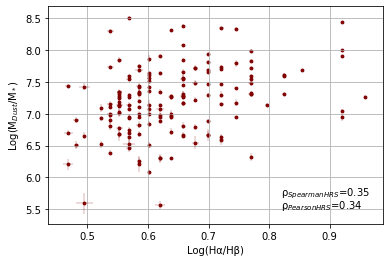

In [28]:
plt.scatter(filtered_HRS_BDec,filtered_HRS_DustM,s=8,c="maroon")
plt.errorbar(filtered_HRS_BDec,filtered_HRS_DustM,yerr = [filtered_HRS_DustMlowerr,filtered_HRS_DustMuperr],xerr = filtered_HRS_BDecerr,linestyle = "none",elinewidth = 0.3,c="maroon")

plt.xlabel("Log(H\u03B1/H\u03B2)")
plt.ylabel("Log(M$_{Dust}$/M$_*$)")
# plt.colorbar() # Because expAB had nan values in some locations, was plotting points with no color, meaning they wouldn't get plotted
plt.grid()

plt.text(0.82,5.52,"\u03C1$_{Pearson HRS}$=%.2f" % PearsonRhoHRS) 
plt.text(0.82,5.72,"\u03C1$_{Spearman HRS}$=%.2f" % SpearmanRhoHRS)

plt.savefig("HRS_BdecvsDustM.png",dpi=300)

plt.show()

Plot of Balmer decrement vs. Dust Mass of HRS galaxies with S/N ratio above 5

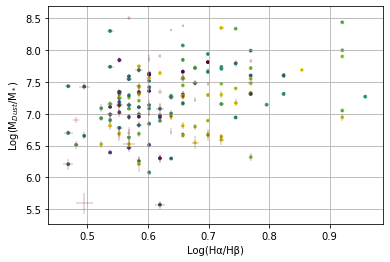

In [29]:
plt.scatter(filtered_HRS_BDec,filtered_HRS_DustM,s=8,c=filtered_HRS_incl) # Get inclinations in here at some point
plt.errorbar(filtered_HRS_BDec,filtered_HRS_DustM,yerr = [filtered_HRS_DustMlowerr,filtered_HRS_DustMuperr],xerr = filtered_HRS_BDecerr,linestyle = "none",elinewidth = 0.3,c="maroon")

plt.xlabel("Log(H\u03B1/H\u03B2)")
plt.ylabel("Log(M$_{Dust}$/M$_*$)")
# plt.colorbar()
plt.grid()
# plt.text(1.1,7.1,"Inclination",rotation = -90)

plt.show()

Plot of Balmer decrement vs. Dust Mass vs. Inclination of HRS galaxies with S/N ratio above 5

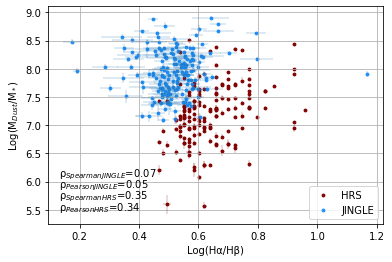

In [45]:
plt.scatter(filtered_HRS_BDec,filtered_HRS_DustM,s=8,c="maroon",label="HRS")
plt.errorbar(filtered_HRS_BDec,filtered_HRS_DustM,yerr = [filtered_HRS_DustMlowerr,filtered_HRS_DustMuperr],xerr = filtered_HRS_BDecerr,linestyle = "none",elinewidth = 0.3,c="maroon")
plt.scatter(filtered_Jing_Bdec,filtered_Jing_Mdust,c="dodgerblue",s=8,label="JINGLE")
plt.errorbar(filtered_Jing_Bdec,filtered_Jing_Mdust,yerr = [filtered_Jing_Mdustlowerr,filtered_Jing_Mdustuperr],xerr = filtered_Jing_Bdecerr,linestyle = "none",elinewidth = 0.3)

plt.xlabel("Log(H\u03B1/H\u03B2)")
plt.ylabel("Log(M$_{Dust}$/M$_*$)")
plt.legend(loc=4)

plt.text(0.13,5.5,"\u03C1$_{Pearson HRS}$=%.2f" % PearsonRhoHRS) 
plt.text(0.13,5.7,"\u03C1$_{Spearman HRS}$=%.2f" % SpearmanRhoHRS)
plt.text(0.13,5.9,"\u03C1$_{Pearson JINGLE}$=%.2f" % PearsonRhoJing) # Has NAN values to clean out
plt.text(0.13,6.1,"\u03C1$_{Spearman JINGLE}$=%.2f" % SpearmanRhoJing)

plt.grid()

plt.savefig("HRSandJINGLE_BdecvsMDust.png",dpi=300)

plt.show()

Plot of Balmer decrement vs. Dust Mass vs. Inclination of HRS & Jingle galaxies with S/N ratio above 5

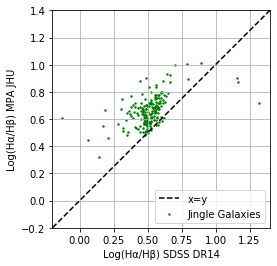

In [31]:
plt.scatter(jingmdrdf["BDec"],jingmdrdf["MPA LBdec"],s=2,label="Jingle Galaxies",c="g")
plt.plot([-1,3],[-1,3],label="x=y",c="black",linestyle="--")
plt.grid()

plt.xlim(-0.2,1.4)
plt.legend(loc=4)
plt.ylim(-0.2,1.4)

plt.xlabel("Log(H\u03B1/H\u03B2) SDSS DR14")
plt.gca().set_aspect('equal', adjustable='box')
plt.ylabel("Log(H\u03B1/H\u03B2) MPA JHU")
plt.savefig("Bdec of MPA vs SDSS.png",dpi=300)

plt.show() # first graph

In [47]:
size = 8
print(len(filtLCOJing),len(filtBDecMPAJing),len(filtMDust))

117 116 116


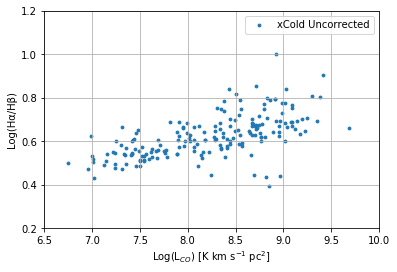

In [50]:
plt.scatter(filtLCOX,filtBalmX,label="xCold Uncorrected",s=size)
# plt.scatter(filtLCOCORX,filtBalmX,label="xCold Aperture Corrected",s=size)
# plt.scatter(filtLCOJing,filtBDecSDSSJing,label="JINGLE from SDSS",s=size)
# plt.scatter(filtLCOJing,filtBDecMPAJing,label="JINGLE from MPA JHU",s=size)
plt.grid()

plt.xlim(6.5,10)
plt.ylim(0.2,1.2)

plt.legend()
plt.xlabel("Log(L$_{CO}$) [K km s$^{-1}$ pc$^2$]")
plt.ylabel("Log(H\u03B1/H\u03B2)")

plt.savefig("LCO vs BDec different surveys.png",dpi=300)

plt.show()

ValueError: x and y must be the same size

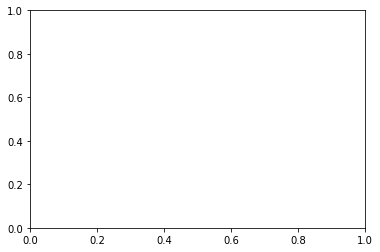

In [37]:
plt.scatter(filtMDust,filtLCOJing,s=size,c="maroon",label="JINGLE Galaxies")

PrhoMDvLCO, PPvalMDvLCO = sps.pearsonr(filtMDust,filtLCOJing)
SrhoMDvLCO, SPvalMDvLCO = sps.spearmanr(filtMDust,filtLCOJing)

plt.grid()
plt.legend(loc=2)

plt.text(7.1,9.6,"\u03C1$_{Pearson}$=%.2f" % PrhoMDvLCO)
plt.text(7.1,9.45,"\u03C1$_{Spearman}$=%.2f" % SrhoMDvLCO)

plt.ylabel("Log(L$_{CO}$) [K km s$^{-1}$ pc$^2$]")
plt.xlabel("Log(M$_{Dust}$/M$_*$)")
plt.xlim(7,9)
plt.ylim(7.5,10)

plt.savefig("MDust vs LCO JINGLE.png",dpi=300)

plt.show()

In [ ]:
size=10

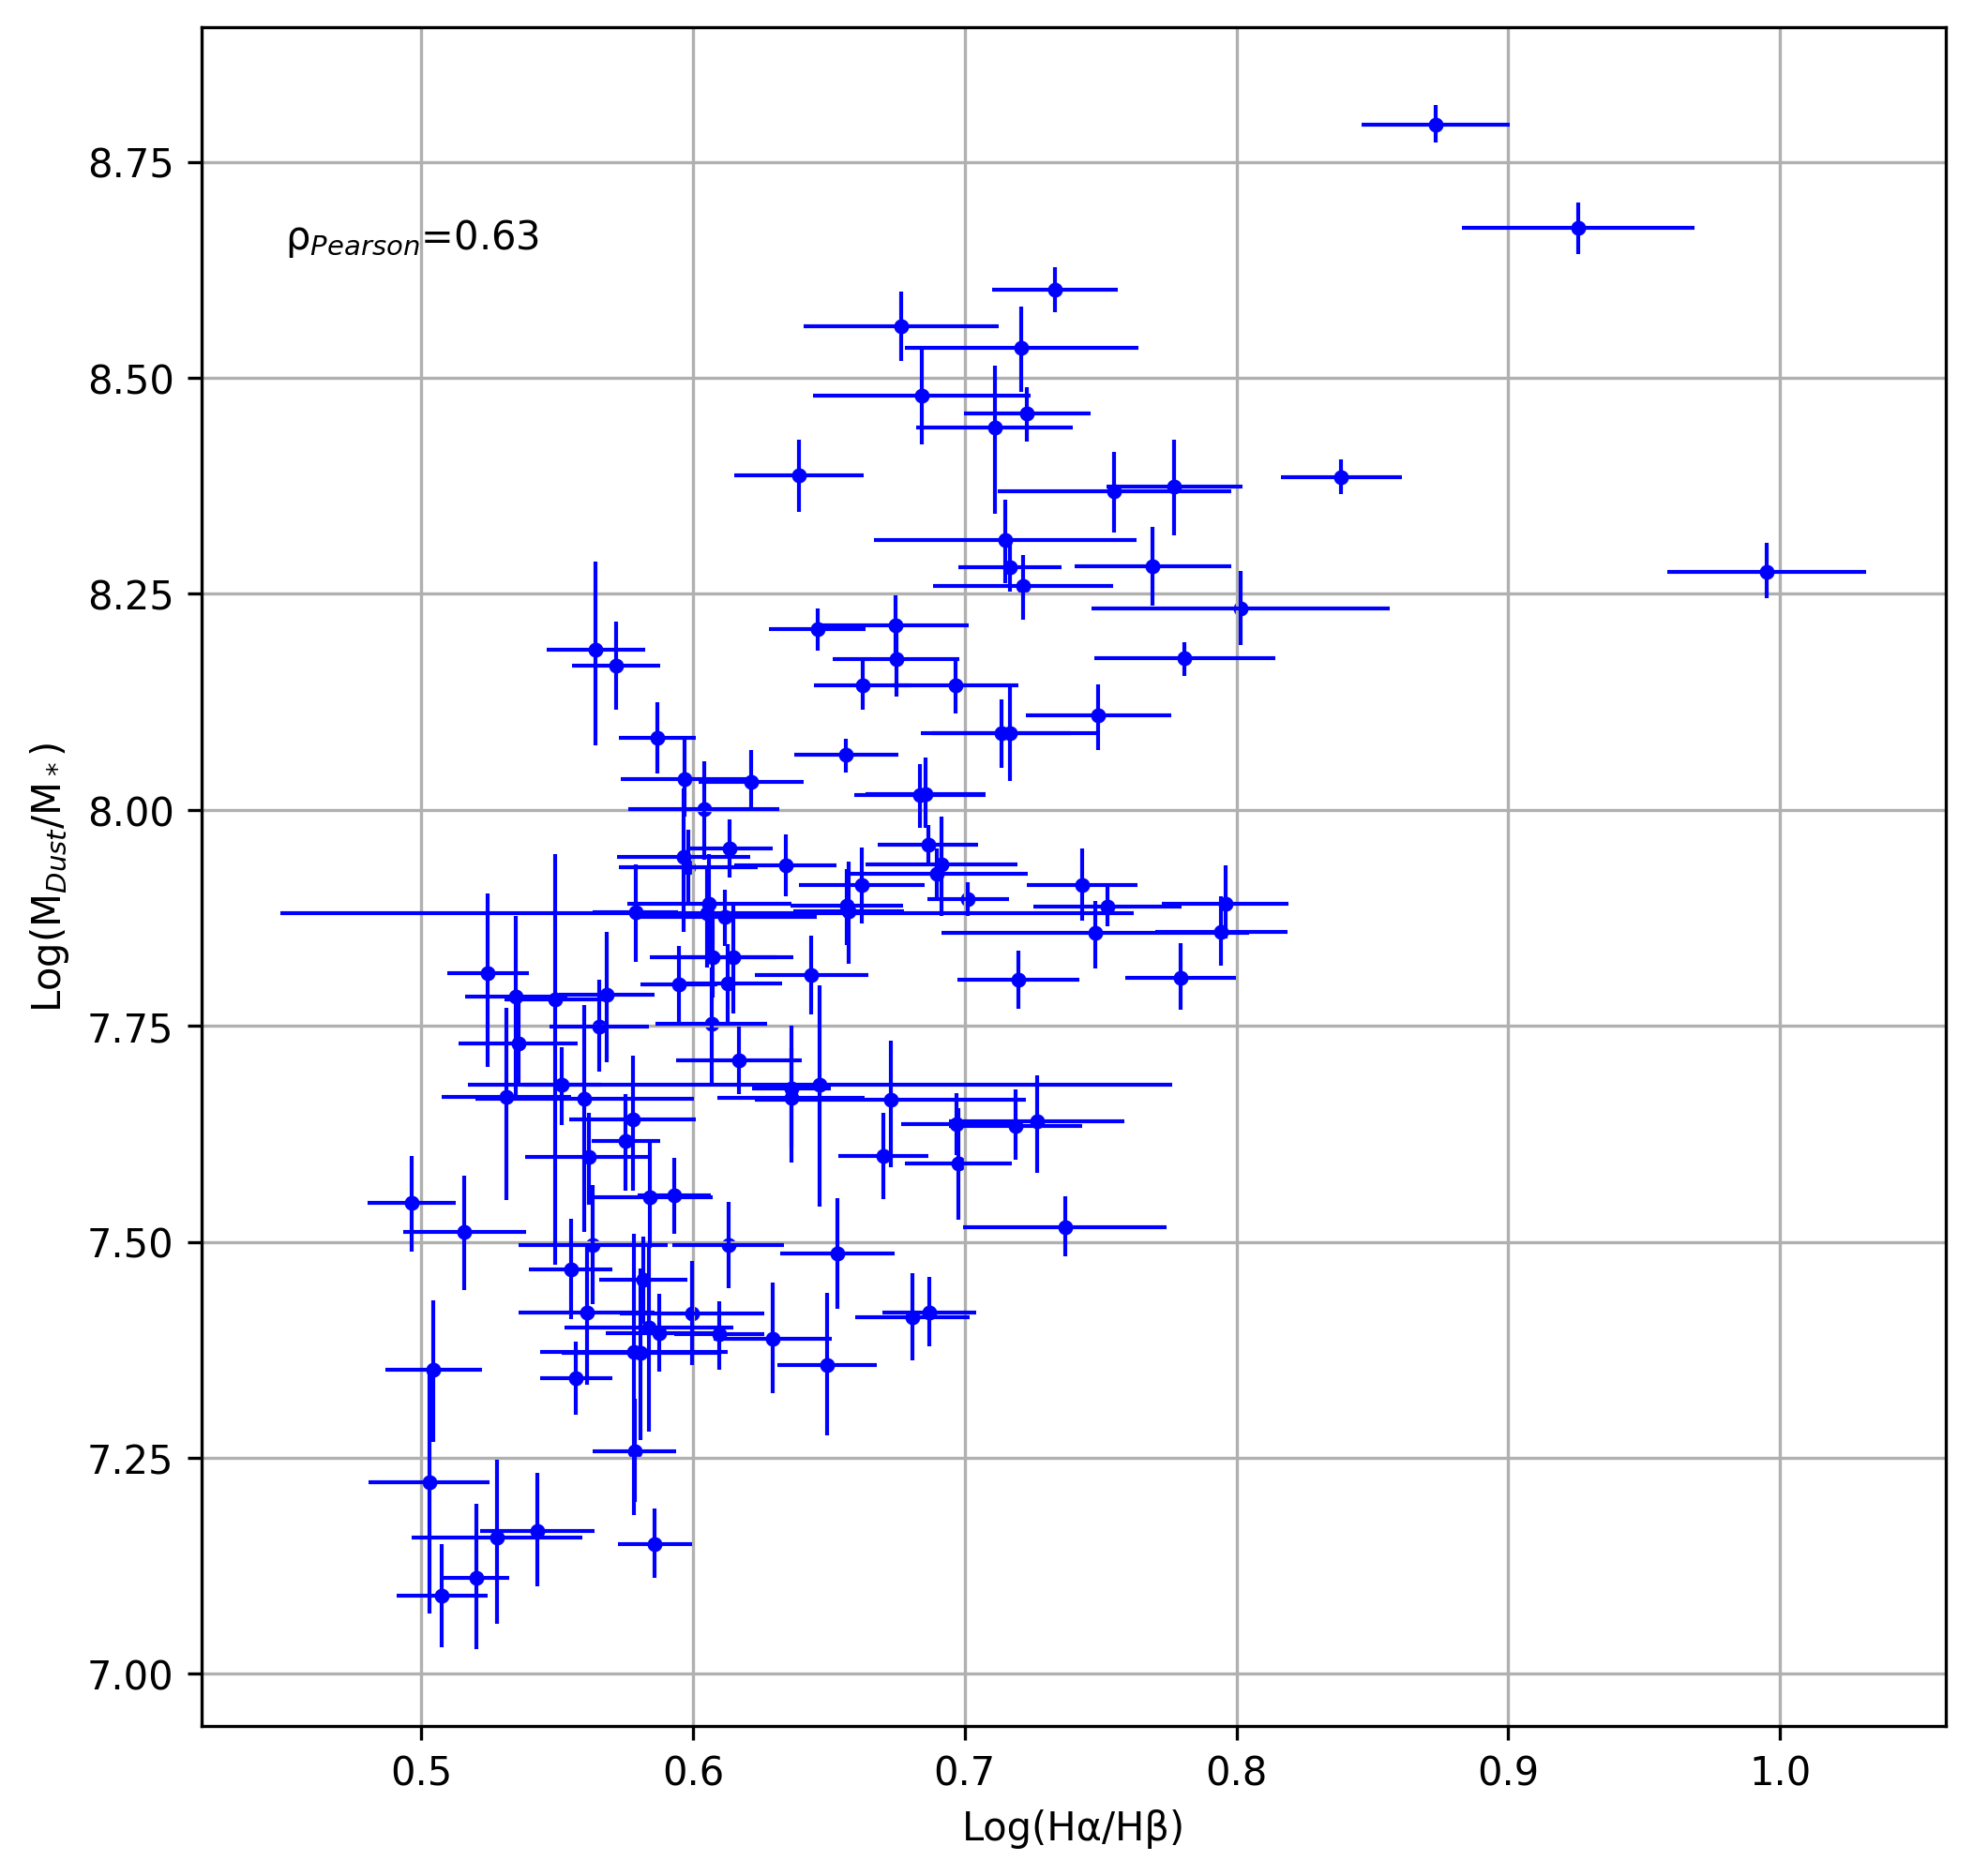

In [120]:
plt.figure(figsize=(8,8),dpi=300)

plt.scatter(filtBDecMPAJing,filtMDust,c="blue",s=size,label="JINGLE")
plt.errorbar(filtBDecMPAJing,filtMDust,xerr=filtBDecerrMPAJing,yerr=[filtMDustlowerr,filtMDustuperr],elinewidth=1,linestyle="none",color="blue")
# plt.scatter(filtered_HRS_DustM,filtered_HRS_BDec,s=size,c="g",label="HRS",marker="x")
# plt.legend(loc=[0.07,0.8])

# plt.colorbar(pad=-0.02)
plt.grid()
# plt.text(9.1,0.7,"Inclination",rotation=-90)
plt.ylabel("Log(M$_{Dust}$/M$_*$)")
plt.xlabel("Log(H\u03B1/H\u03B2)")

plt.text(.45,8.65,"\u03C1$_{Pearson}$=%.2f" % PrhoMDvBdec)
# plt.text(7.1,.85,"\u03C1$_{Spearman}$=%.2f" % SrhoMDvBdec)

plt.savefig("MPAJHU Mdust vs Bdec.png",dpi=300)

plt.show()

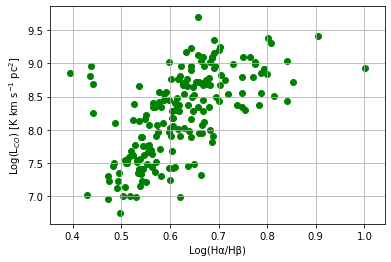

In [115]:
plt.scatter(filtBalmX,filtLCOX,c="g",label="xCold GASS")
# plt.scatter(filt)
plt.grid()
plt.ylabel("Log(L$_{CO}$) [K km s$^{-1}$ pc$^2$]")
plt.xlabel("Log(H\u03B1/H\u03B2)")

plt.show()

### MCMC

In [40]:
# print(len(x))

x, mask = nanmask(np.asarray(filtBalmX))

print(len(mask))
xerrtemp = []
ytemp = []
yerrtemp = []
rang = []
for i in range(len(mask)):
    if mask[i]==True:
        xerrtemp.append(filtBalmErrX[i])
        ytemp.append(filtMH2[i])
        yerrtemp.append(filtMH2err[i])

# print(slice(rang))

xerr = (np.asarray(xerrtemp))
y = (np.asarray(ytemp)) # VARIABLES HERE!!!!
yerr = (np.asarray(yerrtemp))

print(len(x),len(y))

# Dropping nans from balmer decrement setup

0
0 0


In [ ]:
mcMaster = pd.DataFrame(x, columns = ["x"])
mcMaster["y"] = y
mcMaster["xerr"] = xerr
mcMaster["yerr"] = yerr

mcMaster.to_csv("mcCSV.csv")

In [ ]:
sns.set(style="darkgrid", palette="muted")

# ALL OF THIS WAS TAKEN FROM https://www.quantstart.com/articles/Bayesian-Linear-Regression-Models-with-PyMC3

def glm_mcmc_inference(df, iterations=5000):
    """
    Calculates the Markov Chain Monte Carlo trace of
    a Generalised Linear Model Bayesian linear regression 
    model on supplied data.

    df: DataFrame containing the data
    iterations: Number of iterations to carry out MCMC for
    """
    # Use PyMC3 to construct a model context
    basic_model = pm.Model()
    with basic_model:
        # Create the glm using the Patsy model syntax
        # We use a Normal distribution for the likelihood
        pm.glm.GLM.from_formula("y ~ x", df, family=pm.glm.families.Normal())

        # Use Maximum A Posteriori (MAP) optimisation as initial value for MCMC
        start = pm.find_MAP()

        # Use the No-U-Turn Sampler
        step = pm.NUTS()

        # Calculate the trace
        trace = pm.sample(
            iterations, step, start, 
            random_seed=42, progressbar=True
        )

    return trace

In [ ]:
# MDust = x
# BDec = y
# BDec_err = yerr
tuplenames = ["BDec","BDecErr","LCO","LCO err"]

# MDustAveErr = (np.array(filtMDustuperr)+np.array(filtMDustlowerr))/2

# for i in range(len(x)):
#     if x[i]==np.nan or y[i]==np.nan or xerr[i]==np.nan or yerr[i]==np.nan:
#         print(i)

tuples = list(zip(x,xerr,y,yerr)) # Dust data is from dfJingle (I think the june 19th dust file)
# Spectra data is from MPA JHU


df = pd.DataFrame(tuples,columns = tuplenames)

print(type(x[12]))

In [ ]:
# Plot the data, and a frequentist linear regression fit
# using the seaborn package
# sns.lmplot(x=tuplenames[0], y=tuplenames[1], data=df, size=10)
# plt.xlim(0.0, 1.0)

trace = glm_mcmc_inference(df, iterations=10000)
pm.traceplot(trace[500:])
# plt.show()

# Plot a sample of posterior regression lines
sns.lmplot(x=tuplenames[0], y=tuplenames[2], data=df, size=10, fit_reg=True)

'''
# plt.xlim(0.0, 1.0)
# plt.ylim(0.0, 4.0)
# pm.glm.GLM.plot_posterior_predictive(trace, samples=1000)
x = np.linspace(0, 1, N)
y = beta_0 + beta_1*x
plt.plot(x, y, label="True Regression Line", lw=3., c="green")
plt.legend(loc=0)
'''

plt.savefig("pymc3linearfitBDecvsMDust.png",dpi=300)

plt.show()

In [ ]:
print(trace)

In [ ]:
pm.traceplot(trace[500:])

plt.savefig("fitparams.png",dpi=300)

plt.show()

## Starting real MCMC

Code framework courtesy of Thomas Fletcher at UCL

In [38]:


plt.scatter(x,y)

NameError: name 'x' is not defined

In [39]:
min_y = 0.95*max(y)
max_y = 1.05*max(y)
min_x = 0.95*min(x)
max_x = 1.05*max(x)
m_guess = 3
b_guess = 6
logf_guess = 2.5
stepnum = 10**6
burnin = int(0.05*stepnum)

m_prior_range = [-23.2,21.2]
b_prior_range = [-21.5,26.5]
lnf_prior_range = [-25,25]

xlab = "Log(H\u03B1/H\u03B2)"
ylab = "M H$_2$"
mctitle = xlab+" vs. "+ylab +" MCMC fit with "+str(stepnum)+" steps"

NameError: name 'y' is not defined

In [ ]:
def plot_samples_full(sampler, ndim, fname, l): # done
    fig, axes = plt.subplots(ndim, figsize=(10, 20), sharex=True)
    samples = sampler.get_chain()
    labels = l
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(burnin, burnin+stepnum)
        ax.set_ylabel(labels[i])
#         ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number");
#     plt.ylim()
    plt.savefig(fname + '.png', dpi=300)

def plot_corner_full(samples_input, fname, labels): # done
    corner.corner(  samples_input,
                    labels=labels,
                    truths=(np.median(samples_input[:, 0]),
                    np.median(samples_input[:, 1])),
                  truth_color="k",
                  quantiles=[0.16, 0.84], show_titles=True, title_kwargs={"fontsize": 12})
    plt.savefig(fname, dpi=300)

def plot_corner_full2(samples_input, fname, labels): # done
    samples_input[:, 2] = np.exp(samples_input[:, 2])
    corner.corner(  samples_input,
                    labels=labels,
                    truths=(np.median(samples_input[:, 0]),
                    np.median(samples_input[:, 1]),
                    np.median(samples_input[:, 2])),
                  truth_color="k",
                  quantiles=[0.16, 0.84], show_titles=True, title_kwargs={"fontsize": 12})
    plt.savefig(fname, dpi=300)

def plot_results(samples, samples2, x, y , xerr, yerr): # not done
    fig, ax = plt.subplots(nrows = 1, ncols = 1, squeeze=False, figsize=(6,6))
    # plot the data
    ax[0,0].errorbar(x, y, xerr = xerr, yerr = yerr, fmt = 'o')
    x = np.linspace(min_x, max_x, 200)
    # plot 100 random draws from the converged chain with no intrinsic scatter
    for params in samples[np.random.randint(len(samples), size=100)]:
        h1, h2 = params
        ax[0,0].plot(x, h1*x + h2, color = 'g', alpha = 0.1)
    # plot 100 random draws from the converged chain with intrinsic scatter
    for params in samples2[np.random.randint(len(samples2), size=100)]:
        h1, h2, lnh = params
        ax[0,0].plot(x, h1*x + h2, color = 'b', alpha = 0.1)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(mctitle)
#     plt.legend()
    plt.savefig('test_straight_line.png',dpi=300)
    
# Stuff below hhere is straight line specific

def straight_line(x, params):
    m, b = params
    return (m*x) + b

def straight_line_params(params):
    m, b = params
    # unifrom flat priors on m and b between these ranges (can vary these)
    if  m_prior_range[0] < m < m_prior_range[1] and \
        b_prior_range[0] < b < b_prior_range[1]:
        return 0
    # if the params drawn outside the above ranges we make it very unlikely
    return -np.inf

def log_likelihood_straight_line(params):
    # log likelihood explained in: https://dfm.io/posts/fitting-a-plane/ (Eq 9)
    m, b = params
    model = straight_line(x, params)
    deltaN = y - model
    sigma_sq = np.square(xerr*m) + np.square(yerr)
    log_likelihood = -0.5 * np.sum(np.square(deltaN) / sigma_sq + np.log(sigma_sq))
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    return log_likelihood + straight_line_params(params)

def straight_line_params2(params):
    m, b, lnf = params
    # uniform flat priors on m and b between these ranges (can vary these)
    if  m_prior_range[0] < m < m_prior_range[1] and b_prior_range[0] < b < b_prior_range[1] and lnf_prior_range[0] < lnf < lnf_prior_range[1]:
        return 0
    # if the params drawn outside the above ranges we make it very unlikely
    return -np.inf

def log_likelihood_straight_line2(params):
    # log likelihood explained in: https://dfm.io/posts/fitting-a-plane/ (Eq 14-16)
    m, b, lnf = params
    params2 = m, b
    model = straight_line(x, params2)
    deltaN = y - model
    sigma_sq = np.square(xerr*m) + np.square(yerr) + np.exp(2 * lnf)
    log_likelihood = -0.5 * np.sum((np.square(deltaN)/sigma_sq) + np.log(sigma_sq))
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    return log_likelihood + straight_line_params2(params)

In [ ]:
# code for model, params for a plane!!

In [ ]:
#-------------------------------------------------------------------------------
# emcee inference for straight line (no intrinsic scatter)
#-------------------------------------------------------------------------------
# set the number of dimensions (2 parameters) and number of walkers
ndim, nwalkers = 2, 100
# initial guess for the slope and y-intercept
g = [m_guess, b_guess]
# param labels to send to plot functions
param_labels = ['m', 'b']
# make a cluster of pts around the guesses for the walkers
pos = [g + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
# setup emcee to run with 'log_likelihood_straight_line' function as the log likelihood
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_straight_line)
# run emcee for 1000 steps
sampler.run_mcmc(pos, stepnum+burnin, progress=True)
# print the acceptance fraction to give us an idea whether it is working
af = sampler.acceptance_fraction
print("Mean acceptance fraction:", np.mean(af))
# take only values after the chain has converged
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))


# use function to plot the chain for each parameter to see if/when it converged
plot_samples_full(sampler, ndim, 'chains', param_labels)

# make a corner plot for chain after convergence
plot_corner_full(samples, 'corner.pdf', param_labels)

In [49]:
#-------------------------------------------------------------------------------
# emcee inference for straight line (intrinsic scatter)
#-------------------------------------------------------------------------------
# set the number of dimensions (2 parameters) and number of walkers
ndim, nwalkers = 3, 100
# initial guess for the slope and y-intercept
g2 = [m_guess, b_guess, logf_guess]
# param labels to send to plot functions
param_labels = ['m', 'b', 'lnf']
# make a cluster of pts around the guesses for the walkers
pos2 = [g2 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
# setup emcee to run with 'log_likelihood_straight_line' function as the log likelihood
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_straight_line2)
# run emcee for n steps
sampler2.run_mcmc(pos2, stepnum+burnin, progress=True)
# print the acceptance fraction to give us an idea whether it is working
af = sampler2.acceptance_fraction
print("Mean acceptance fraction:", np.mean(af))
# take only values after the chain has converged
samples2 = sampler2.chain[:, burnin:, :].reshape((-1, ndim)) # burn in??

NameError: name 'm_guess' is not defined

In [ ]:
# use function to plot the chain for each parameter to see if/when it converged
plot_samples_full(sampler2, ndim, 'chains2', param_labels)

In [ ]:
# make a corner plot for chain after convergence
plot_corner_full2(samples2, 'corner_intrinsic.png', param_labels)

In [ ]:
# plot the data, and best fit lines for both methods
plot_results(samples, samples2, x, y , xerr, yerr)

### Importing MPA data to sample from

In [20]:
gal_line_name = "gal_line_dr7_v5_2 (1).fit"
gal_info_name = "gal_info_dr7_v5_2 (1).fit"
gal_fib_name = "gal_fiboh_dr7_v5_2.fits"

gal_line_tab = Table.read(gal_line_name, format='fits')
gal_line_df = gal_line_tab.to_pandas() # this thang works
gal_info_tab = Table.read(gal_info_name, format='fits')
gal_info_df = gal_info_tab["RA","DEC","Z","E_BV_SFD"].to_pandas()
gal_fib_tab = Table.read(gal_fib_name, format='fits')
gal_fib_df = gal_fib_tab.to_pandas()

mpaSMassName = "MPA StellarMassdata.fit"
mpaSFRName = "MPA SFRdata.fits"
mpaSMass_tab = Table.read(mpaSMassName, format='fits')
mpaSFR_tab = Table.read(mpaSFRName, format='fits')
mpaSMass_df = mpaSMass_tab.to_pandas()
mpaSFR_df = mpaSFR_tab.to_pandas()

from astropy.table import Table
matchdf = Table.read("CAS-IDs.fits", format='fits').to_pandas()

galtype_fname = "gal_iclass_table_dr7_v5_2.fits"
galtype_tab = Table.read(galtype_fname, format='fits')
galtype_df = galtype_tab.to_pandas()

In [21]:
expABfname = "MyTable_0_Seannieboyy.csv"
expABdf = pd.read_csv(expABfname)
print(expABdf.columns.values)

['objID' 'ra1' 'dec1' 'Column1' 'distance' 'ra2' 'dec2' 'expAB_r']


In [22]:
# print("Starmass: ",mpaSMass_df.columns.values) # Starmass data here
# print("SFR: ", mpaSFR_df.columns.values) # SFR data here
# print("GAL line: ",gal_line_df.columns.values) # Spectra data in here, individual line fluxes already in master
# print("GAL info: ",gal_info_tab.columns.values) # This one has Z's, already in master
print("GAL FIB: ", gal_fib_df.columns.values) # metallicities in here

mpamaster = pd.DataFrame(gal_info_tab["Z"], columns=["Z"])
mpamaster["Z err"] = gal_info_tab["Z_ERR"]

mpamaster["H alpha flux"] = gal_line_df['H_ALPHA_FLUX']
mpamaster["H alpha flux error"] = gal_line_df['H_ALPHA_FLUX_ERR']
mpamaster["H beta flux"] = gal_line_df['H_BETA_FLUX']
mpamaster["H beta flux error"] = gal_line_df['H_BETA_FLUX_ERR']

mpamaster["BDec"] = np.log10(mpamaster["H alpha flux"]/mpamaster["H beta flux"])
mpamaster["BDec Err"] = np.log10(np.exp(1))*(mpamaster["H beta flux"]/mpamaster["H alpha flux"])*np.sqrt((mpamaster["H alpha flux error"]/mpamaster["H alpha flux"])**2+(mpamaster["H beta flux error"]/mpamaster["H beta flux"])**2)

mpamaster["objid"] = matchdf["OBJID"]

mpamaster["expAB_r"] = expABdf["expAB_r"]

mpamaster["RA"] = gal_info_tab["RA"]
mpamaster["DEC"] = gal_info_tab["DEC"]

mpamaster["StarMass"] = mpaSMass_df["MEDIAN"]
mpamaster["StarMass P16"] = mpaSMass_df["P16"]
mpamaster["StarMass P84"] = mpaSMass_df["P84"]
# mpamaster["Starmass UNC"] = np.log10(np.exp(1))*(mpamaster["StarMass"])*np.sqrt((mpamaster["H alpha flux error"]/mpamaster["H alpha flux"])**2+(mpamaster["H beta flux error"]/mpamaster["H beta flux"])**2)

mpamaster["SFR"] = mpaSFR_df["MEDIAN"]
mpamaster["SFR P16"] = mpaSFR_df["P16"]
mpamaster["SFR P84"] = mpaSFR_df["P84"]
mpamaster["SFR err"] = (mpaSFR_df["P16"]+mpaSFR_df["P84"])/2
mpamaster["SFR FLAG"] = mpaSFR_df["FLAG"]
mpamaster["SFR ENTROPY"] = mpaSFR_df["ENTROPY"]

mpamaster["GALAXY CLASS"] = galtype_df["I_CLASS"]

mpamaster["12+LOG OH"] = gal_fib_df["MEDIAN"]
mpamaster["12+LOG OH P16"] = gal_fib_df["P16"]
mpamaster["12+LOG OH P84"] = gal_fib_df["P84"]
mpamaster["12+LOG OH err"] = (gal_fib_df["P16"]+gal_fib_df["P84"])/2

mpamaster["EB-V"] = gal_info_df["E_BV_SFD"]

GAL FIB:  ['MEDIAN' 'P16' 'P84' 'P2P5' 'P97P5' 'MODE' 'AVG' 'ENTROPY']


In [23]:
data={"objID":np.asarray(mpamaster["objid"]),"ra":np.asarray(mpamaster["RA"]),"dec":np.asarray(mpamaster["DEC"])}
tmpdf = pd.DataFrame(data)
# print(tmpdf.columns.values)
tmpdf.to_csv("OBJIDs.csv") # used for crossmatch

In [24]:
zlower,zupper = 0,0.06
starmasslowbound,starmassupbound = 9,13
MH2Lowbound,MH2Upbound = 4,13
BDecLowbound,BDecUpbound = 0.35,1

goodnesslist = []
removeindex = []

for i in range(len(mpamaster)):
    if mpamaster["Z"][i]<zlower or mpamaster["Z"][i]>zupper or mpamaster["StarMass"][i]<starmasslowbound or mpamaster["StarMass"][i]>starmassupbound or mpamaster["BDec"][i]<BDecLowbound or mpamaster["BDec"][i]>BDecUpbound: # boundaries here
        removeindex.append(i)
    else:
        goodnesslist.append(i)
        
mpamaster = mpamaster.drop(removeindex)

In [ ]:
m_MDust = 2.57
b_MDust = 6.17

m_MH2 = 2.81
b_MH2 = 7.21

m_LCO = 4.34
b_LCO = 5.53

mpamaster["MDust_MCMC"] = mpamaster["BDec"]*m_MDust+b_MDust
mpamaster["MH2_MCMC"] = mpamaster["BDec"]*m_MH2+b_MH2
mpamaster["LCO_MCMC"] = mpamaster["BDec"]*m_LCO+b_LCO

mpamaster["GasFrac"] = np.log10((10**(mpamaster["MH2_MCMC"]))/(10**(mpamaster["StarMass"])))

In [25]:
idlist = []
for i in range(len(mpamaster)):
    idlist.append(i)
mpamaster["NUMID"] = idlist

print(mpamaster.columns.values)

['Z' 'Z err' 'H alpha flux' 'H alpha flux error' 'H beta flux'
 'H beta flux error' 'BDec' 'BDec Err' 'objid' 'expAB_r' 'RA' 'DEC'
 'StarMass' 'StarMass P16' 'StarMass P84' 'SFR' 'SFR P16' 'SFR P84'
 'SFR err' 'SFR FLAG' 'SFR ENTROPY' 'GALAXY CLASS' '12+LOG OH'
 '12+LOG OH P16' '12+LOG OH P84' '12+LOG OH err' 'EB-V' 'NUMID']


In [26]:
mpamaster.to_csv("MPAMaster.csv")

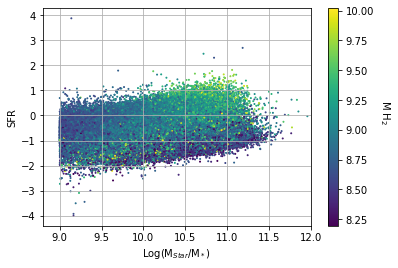

In [68]:
plt.scatter(mpamaster["StarMass"],mpamaster["SFR"],c=mpamaster["MH2_MCMC"],s=1)

# this graph, but better

plt.colorbar()
# plt.clim(7,11)

plt.grid()

plt.xlabel(StarMassLabel)
plt.ylabel(SFRLabel)
plt.xlim(8.8,12)

plt.text(12.8,-0.2,"M H$_2$", rotation=-90)

plt.savefig("MStarvsSFR_Colorize_H2.png",dpi=300)

plt.show()

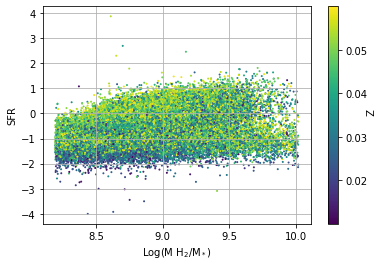

In [12]:
# plot MH2 vs log SFR

plt.scatter(mpamaster["MH2_MCMC"],mpamaster["SFR"],s=1,c=mpamaster["Z"])
plt.grid()
plt.xlabel(MH2Label)
plt.ylabel(SFRLabel)

plt.colorbar()
plt.text(10.5,0,"Z",rotation=-90)

plt.savefig("MH2vsSFR_colorZ.png",dpi=300)

plt.show()

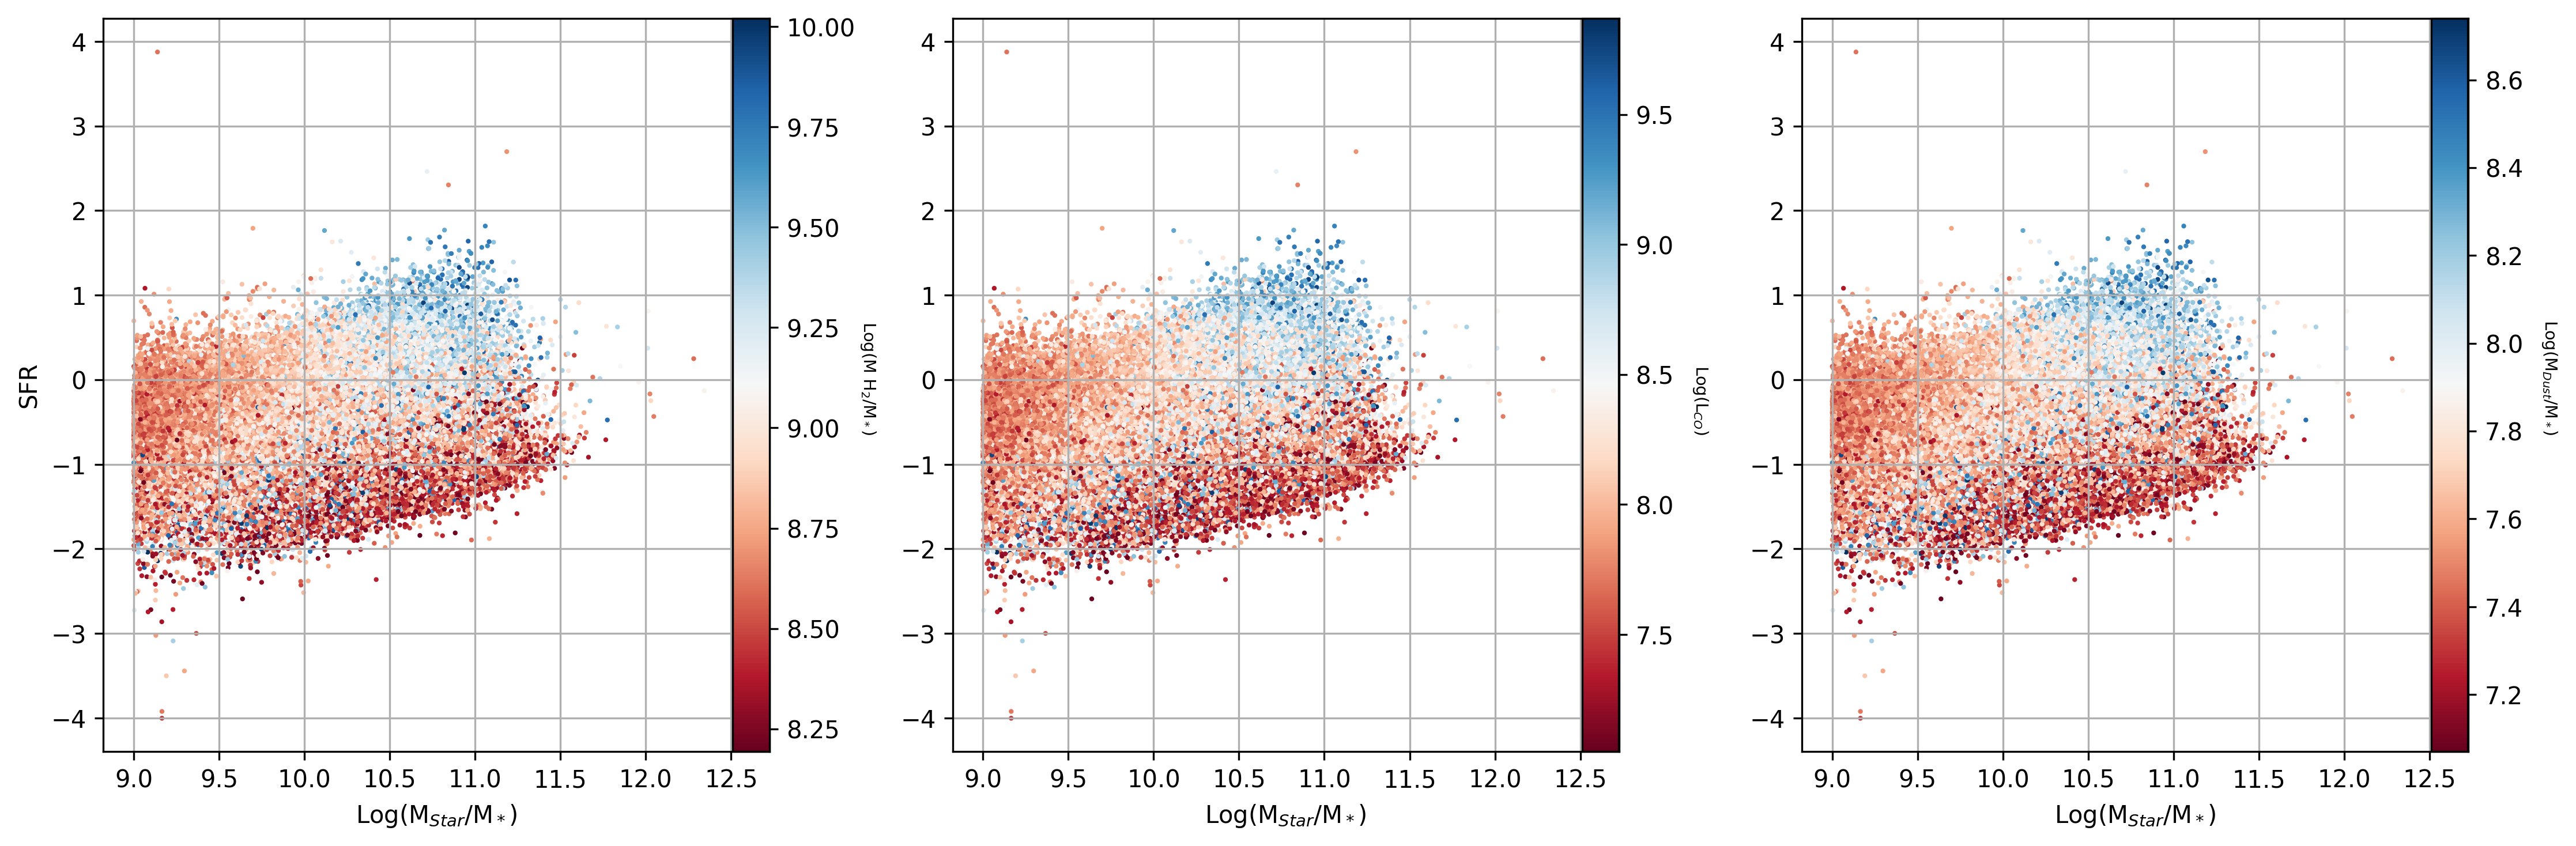

In [13]:
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import make_axes_locatable
figure(num=None, figsize=(15, 5), dpi=300, facecolor='w', edgecolor='k')

plt.subplot(1, 3, 1)

plt.scatter(mpamaster["StarMass"],mpamaster["SFR"],c=(mpamaster["MH2_MCMC"]),s=1,cmap = "RdBu")
plt.grid()
plt.xlabel(StarMassLabel)
plt.axis("tight")
plt.ylabel(SFRLabel)
plt.colorbar(pad=-0.05,)

plt.text(13.25,-.6, MH2Label, rotation = -90,size="x-small")

plt.subplot(1, 3, 2)

plt.scatter(mpamaster["StarMass"],mpamaster["SFR"],c=mpamaster["LCO_MCMC"],s=1,cmap="RdBu")
plt.grid()
plt.xlabel(StarMassLabel)
# plt.ylabel(SFRLabel)
plt.axis("tight")
plt.colorbar(pad=-0.05,)
plt.text(13.15,-0.6, LCOLabel, rotation = -90,size="x-small")

plt.subplot(1, 3, 3)

plt.scatter(mpamaster["StarMass"],mpamaster["SFR"],c=mpamaster["MDust_MCMC"],s=1,cmap="RdBu") # colorize this by inclination!!
plt.grid()
plt.xlabel(StarMassLabel)
# plt.ylabel(SFRLabel)
plt.axis("tight")
plt.colorbar(pad=-0.05,)
plt.text(13.15,-0.6, MDustLabel, rotation = -90,size="x-small")

plt.tight_layout()

plt.savefig("xColdComp.png",dpi=300)

plt.show()

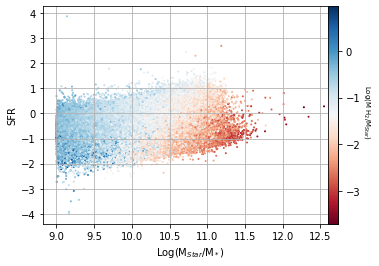

In [14]:
plt.scatter(mpamaster["StarMass"],mpamaster["SFR"],c=(mpamaster["GasFrac"]),s=1,cmap = "RdBu")
plt.grid()
plt.xlabel(StarMassLabel)
plt.axis("tight")
plt.ylabel(SFRLabel)
plt.colorbar(pad=-0.03,)
plt.text(13.05,-.9, "Log(M H$_2$/M$_{Star}$)", rotation = -90,size="x-small")
plt.savefig("GasFracplot.png",dpi=300)

plt.show()

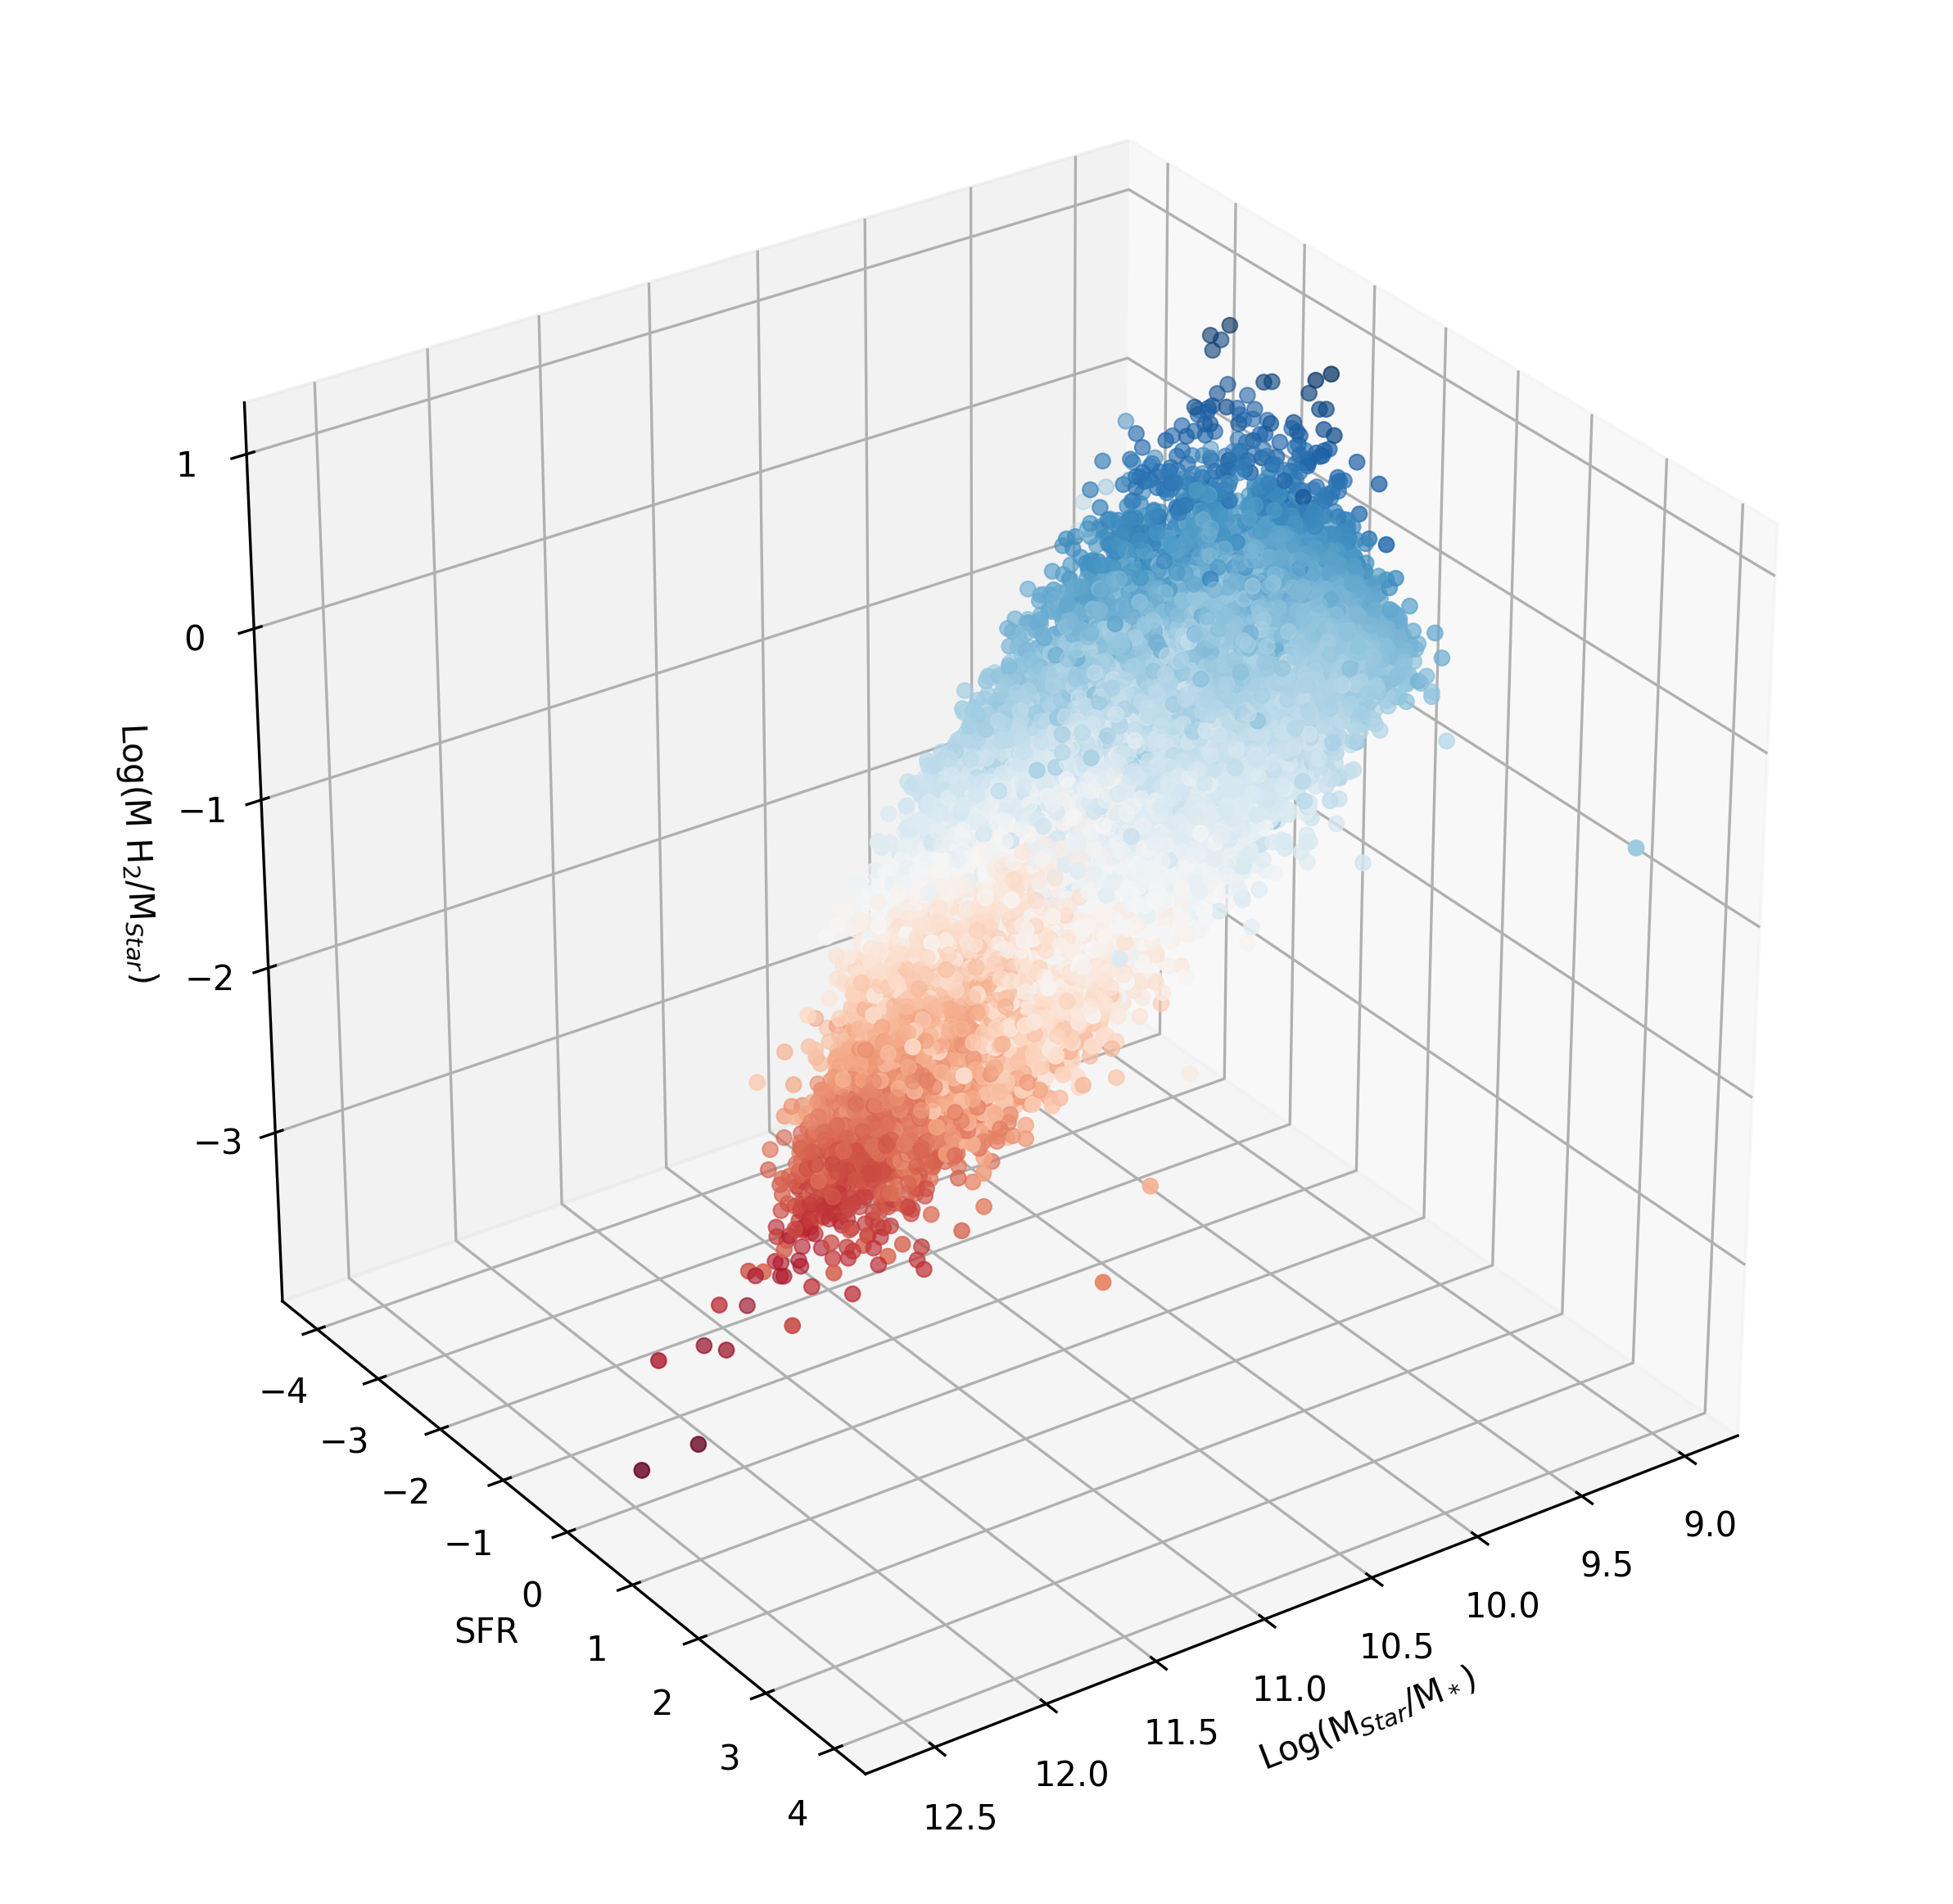

In [15]:
from mpl_toolkits import mplot3d

fig = plt.figure(num=None, figsize=(10, 10), dpi=300, facecolor='w', edgecolor='k')
ax = plt.axes(projection='3d')
ax.scatter(mpamaster["StarMass"],mpamaster["SFR"], mpamaster["GasFrac"], c=mpamaster["GasFrac"], cmap='RdBu', linewidth=0.5)
ax.set_xlabel(StarMassLabel)
ax.set_ylabel(SFRLabel)
ax.set_zlabel("Log(M H$_2$/M$_{Star}$)")

ax.view_init(30, 55)
plt.savefig("3DGasFrac.png",dpi=300)
plt.show()

In [ ]:
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import make_axes_locatable
figure(num=None, figsize=(15, 5), dpi=300, facecolor='w', edgecolor='k')

graphname = ['MDust_MCMC','MH2_MCMC','LCO_MCMC', "GasFrac"]
labels = [MDustLabel,MH2Label,LCOLabel,GasFracLabel]

for i in range(0,3):
    plt.subplot(1, 3, i+1)
    plt.scatter(mpamaster["BDec"],mpamaster["SFR"],c=mpamaster[graphname[i]],s=1)
    plt.grid()
    plt.text(1.12,-1,labels[i],rotation=-90)
    plt.axis("tight")
    if i%2==0:
        plt.ylabel(SFRLabel)
    plt.xlabel(BDecLabel)
    plt.colorbar(pad=-0.05,)

plt.tight_layout()

plt.savefig("MCMCComp.png",dpi=300)

plt.show()

In [20]:
jingmdrdf.to_csv("JINGLEMASTERDEC19.csv")

In [27]:
mpamaster["EB-V"]

0         0.055224
4         0.114275
11        0.052312
22        0.075080
42        0.142181
45        0.135121
74        0.133854
85        0.159249
103       0.162382
107       0.121549
109       0.108101
110       0.112136
111       0.164127
113       0.158406
115       0.119389
116       0.127166
119       0.118711
125       0.159386
160       0.054448
217       0.061438
237       0.059733
251       0.105068
256       0.102390
263       0.140194
284       0.132812
290       0.101177
314       0.108947
317       0.110566
318       0.128573
322       0.116556
            ...   
925848    0.043054
925849    0.039382
925854    0.055658
925855    0.055759
925858    0.054503
925880    0.054775
925882    0.055185
925892    0.058151
925895    0.051698
925898    0.057200
925905    0.053841
925912    0.055228
925922    0.054132
925925    0.057340
925931    0.053751
925932    0.054894
925936    0.054591
925956    0.054855
925979    0.062886
925986    0.055893
926001    0.078037
926008    0.